# **SPEECH RECOGNITION**

## Preprocess data

In [ ]:
# import libraries
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile

In [ ]:
# obtain training data's sample rate
trainDir = '/content/train/audio/'
samples, sample_rate = librosa.load(trainDir+'bed/00176480_nohash_0.wav', sr = 16000)
ipd.Audio(samples, rate = sample_rate)
print(sample_rate)

16000


In [ ]:
# resample the sample rate
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate = 8000)

In [ ]:
# train folder directory
labels = os.listdir(trainDir)

In [ ]:
# loop through .wav files
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(trainDir + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))

In [ ]:
labels = ["bed", "bird", "cat", "dog", "down", "eight", "five", "four"]

(array([2.0000e+00, 6.0000e+00, 4.7000e+01, 3.0000e+01, 1.0600e+02,
        1.6300e+02, 2.5500e+02, 2.1900e+02, 3.7400e+02, 1.5161e+04]),
 array([0.384 , 0.4456, 0.5072, 0.5688, 0.6304, 0.692 , 0.7536, 0.8152,
        0.8768, 0.9384, 1.    ]),
 <a list of 10 Patch objects>)

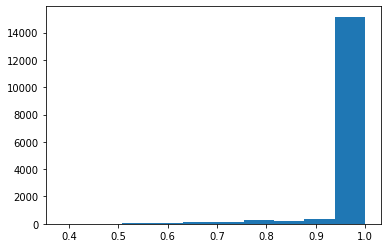

In [ ]:
# loop through duration of recordings
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(trainDir + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(trainDir + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
 # plot number of recordings   
plt.hist(np.array(duration_of_recordings))

In [ ]:
# read dataset and resample each audio file
trainDir = '/content/train/audio/'
all_wave = []
all_label = []

for label in labels:
    print(label)
    waves = [f for f in os.listdir(trainDir + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(trainDir + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

bed
bird
cat
dog
down
eight
five
four


In [ ]:
# encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(all_label) 
classes = list(le.classes_)
print(classes)

['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four']


In [ ]:
# take labels as categorical
from keras.utils import np_utils
y = np_utils.to_categorical(y, num_classes=len(labels))

In [ ]:
# reshape to three-dimensional array
all_wave = np.array(all_wave).reshape(-1, 8000, 1)

In [ ]:
# split dataset
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),
                                            np.array(y),
                                            stratify = y,
                                            test_size = 0.2,
                                            random_state=777,
                                            shuffle=True)

## Train the model

In [ ]:
# build the model
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1)) # one-dimensional

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2662, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2662, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 884, 16)          

In [ ]:
# compile the model
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
# early stopping if model is not improving
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 10, min_delta = 0.0001) 
mc = ModelCheckpoint('voiceRecModel.hdf5', monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')
print(x_tr.shape, x_val.shape, y_tr.shape, y_val.shape)

(11719, 8000, 1) (2930, 8000, 1) (11719, 8) (2930, 8)


In [ ]:
# train the model
history = model.fit(x_tr, y_tr ,epochs = 100, callbacks=[es, mc], batch_size = 32, validation_data=(x_val, y_val))

Epoch 1/100
367/367 [==============================] - 5s 12ms/step - loss: 1.8122 - accuracy: 0.2978 - val_loss: 1.5885 - val_accuracy: 0.4133
Epoch 2/100
367/367 [==============================] - 4s 12ms/step - loss: 1.2610 - accuracy: 0.5547 - val_loss: 0.9609 - val_accuracy: 0.6846
Epoch 3/100
367/367 [==============================] - 4s 11ms/step - loss: 0.9699 - accuracy: 0.6569 - val_loss: 0.9809 - val_accuracy: 0.6983
Epoch 4/100
367/367 [==============================] - 4s 11ms/step - loss: 0.8416 - accuracy: 0.7071 - val_loss: 0.8031 - val_accuracy: 0.7249
Epoch 5/100
367/367 [==============================] - 4s 12ms/step - loss: 0.7517 - accuracy: 0.7393 - val_loss: 1.0761 - val_accuracy: 0.6174
Epoch 6/100
367/367 [==============================] - 4s 11ms/step - loss: 0.6785 - accuracy: 0.7670 - val_loss: 0.7558 - val_accuracy: 0.7478
Epoch 7/100
367/367 [==============================] - 4s 12ms/step - loss: 0.6220 - accuracy: 0.7903 - val_loss: 0.6027 - val_accuracy:

In [ ]:
# save the model
model.save("/tmp/voiceRecModel.hdf5")

## Test the model

In [ ]:
# load the model
from keras.models import load_model

model = load_model("/tmp/voiceRecModel.hdf5")

In [ ]:
# precict the data
def predict(audio):
    prob = model.predict(audio.reshape(1,8000,1))
    index = np.argmax(prob[0])
    return classes[index]

# choose random data from directory
import random
index = random.randint(0,len(x_val)-1)
samples = x_val[index].ravel()
print("Audio:", classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate = 8000)

Audio: eight


In [ ]:
# print prediction
print("Text:", predict(samples))

Text: eight
